In [ ]:
import torch
from torch import pi
from matplotlib import pyplot as plt

**Heat equation:**

$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$

- Boundary Conditions (for all $t \geq 0$.): 
    - $u(0, t) = 0$
    - $u(1, t) = 0$
- Initial Condition:
    - $u(x, 0) = \sin(\pi x)$ for $0 \leq x \leq 1$.

**Analytical solution:**

$u(x,t) = e^{-\alpha \pi^2 t} \sin(\pi x)$

In [ ]:
def u(x, t, alpha):
    return torch.exp(-alpha*(pi**2)*t)*torch.sin(pi*x)

def du_dt(x, t, alpha):
    return -(alpha*pi**2)*torch.exp(-alpha*t*pi**2)*torch.sin(pi*x)

def d2u_dx2(x, t, alpha):
    return -(pi**2)*torch.exp(-alpha*t*pi**2)*torch.sin(pi*x)

In [ ]:
n_x = 100
n_t = 100
max_t = 100
alpha = 4*1e-8

features, t = torch.linspace(start=0, end=1, steps=n_x), torch.linspace(start=0, end=max_t, steps=n_t)
xx, tt = torch.meshgrid(features, t)
y = u(xx, tt, alpha)

dataset = torch.utils.data.TensorDataset(
    # torch.vstack((xx.flatten(),tt.flatten())).T.requires_grad_(),
    xx.flatten().requires_grad_(),
    tt.flatten().requires_grad_(),
    y.flatten().unsqueeze(1)
    )

/home/andre/anaconda3/envs/hc-dev/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 48),
    torch.nn.GELU(),
    torch.nn.Linear(48, 48),
    torch.nn.Sigmoid(),
    torch.nn.Linear(48, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32,1)
)

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
constraints = [
    lambda _, t: torch.nn.functional.mse_loss(model(torch.vstack((torch.zeros_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)),
    lambda _, t: torch.nn.functional.mse_loss(model(torch.vstack((torch.ones_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)),
    lambda x, _: torch.nn.functional.mse_loss(model(torch.vstack((x, torch.zeros_like(x))).T), torch.sin(torch.pi*x).unsqueeze(1))
]

constraint_multipliers = torch.tensor([0.1, 0.1, 0.1])

In [ ]:
import numpy as np


epochs = 30
mse_loss = torch.nn.MSELoss()
epoch_loss_log = []
epoch_c_log = []
for epoch in range(epochs):
    loss_log = []
    c_log = []
    for x, t, y in loader:
        y_hat = model(
            torch.vstack((x, t)).T
        )

        cs = []
        regularization = 0

        for j, constraint in enumerate(constraints):
            c = constraint(x, t)
            cs.append(c.detach().numpy())
            regularization += constraint_multipliers[j] * c
        c_log.append(np.array(cs))

        jac_x = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=x,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        jac_t = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=t,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        hess_x = torch.autograd.grad(
            outputs=jac_x.unbind(),
            inputs=x,
            create_graph=True,
            materialize_grads=True)[0]

        loss_d = mse_loss(jac_t, alpha*hess_x)
        loss_pred = mse_loss(y_hat, y)

        loss = loss_d + loss_pred + regularization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_log.append(loss.detach().numpy())
    print(sum(loss_log)/len(loss_log))
    epoch_loss_log.append(sum(loss_log)/len(loss_log))
    print(sum(c_log)/len(c_log))
    epoch_c_log.append(sum(c_log)/len(c_log))

0.19166085
[0.28570727 0.28698546 0.12341054]
0.17407602
[0.27949375 0.27911466 0.09686951]
0.17348269
[0.27639878 0.27420366 0.09363556]
0.17093493
[0.2760923  0.2698594  0.07824789]
0.15064213
[0.23343506 0.2580484  0.02550809]
0.09784676
[0.11729922 0.19079283 0.01866407]
0.029571772
[0.02167878 0.04516963 0.01146942]
0.009797525
[0.00365482 0.01532126 0.00595457]
0.004653558
[0.00183157 0.00663807 0.00413095]
0.0037781312
[0.00182409 0.00469831 0.0025555 ]
0.003013322
[0.00156981 0.00322    0.00166302]
0.0022660403
[0.00135081 0.00226969 0.00099064]
0.0014112822
[0.00094034 0.00133363 0.00048819]
0.0011823503
[0.00075862 0.00111081 0.00021735]
0.00049848075
[0.00034647 0.00041833 0.00011419]
0.0027912243
[0.00160175 0.00316123 0.00023517]
0.000438347
[3.5337769e-04 3.6862268e-04 6.3583648e-05]
0.00046133282
[3.2100611e-04 3.3319049e-04 3.6085876e-05]
0.0014243633
[7.2418340e-04 1.4362701e-03 5.2210264e-05]
0.0002420183
[2.3347251e-04 1.3934702e-04 2.6262442e-05]
0.0014424601
[7.269

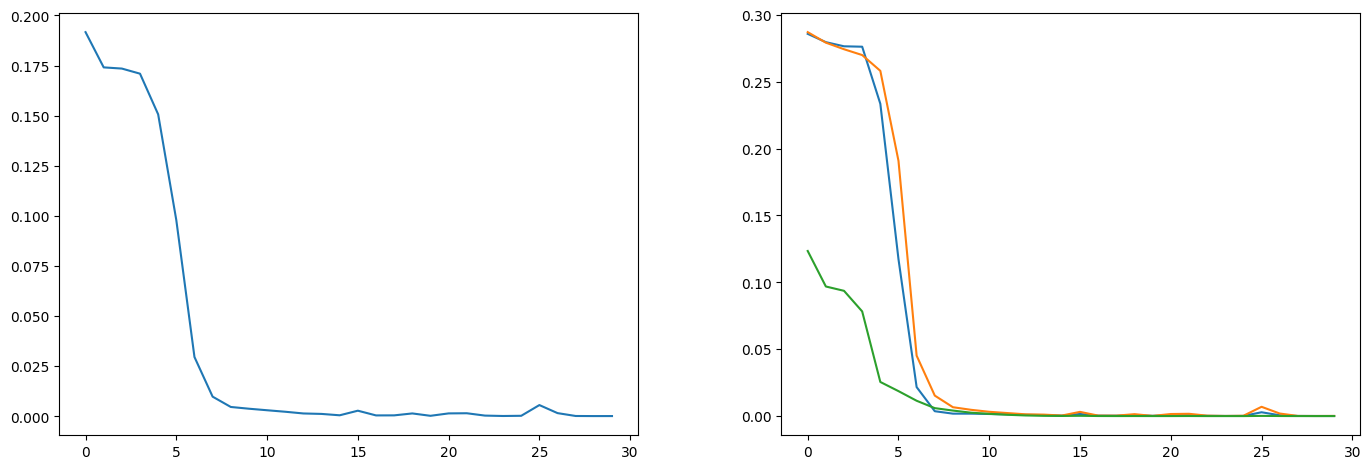

In [ ]:
f = plt.figure()
ax = f.subplots(1,2)
ax[0].plot(epoch_loss_log)
ax[1].plot(epoch_c_log)
f.tight_layout()
f.set_figwidth(15)

Overall MSE
tensor(3.1768e-05)
MSE on jacobian-hessian relation
tensor(7.6679e-06)
MSE on x=0
tensor(2.6804e-06)
MSE on x=1
tensor(8.6490e-06)
MSE on t=0
tensor(2.7333e-05)


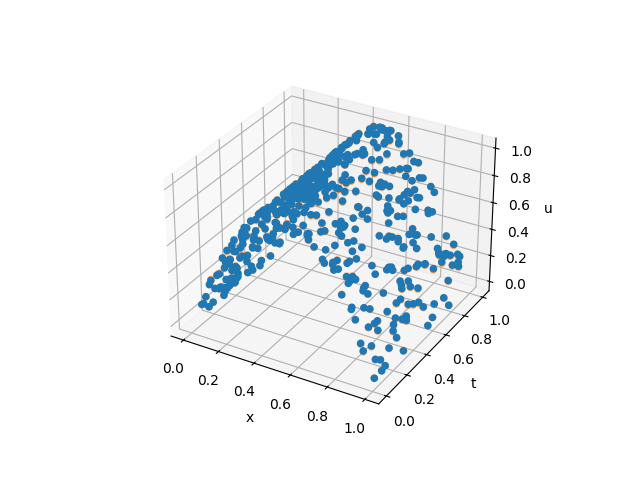

In [ ]:
%matplotlib ipympl


torch.manual_seed(0)
x = torch.rand(500).requires_grad_()
t = torch.rand(500).requires_grad_()
preds = model(torch.vstack((x, t)).T).unbind()
jac_t = torch.autograd.grad(
        outputs=preds,
        inputs=t,
        grad_outputs=None,
        create_graph=True,
        materialize_grads=True)[0]
hess_x = torch.autograd.grad(
        outputs=jac_x.unbind(),
        inputs=x,
        create_graph=True,
        materialize_grads=True)[0]
loss_d = torch.nn.functional.mse_loss(jac_t, alpha*hess_x).detach()

with torch.inference_mode():
    _u = u(x, t, alpha=alpha)
    preds = model(torch.vstack((x, t)).T).flatten()
    print('Overall MSE')
    print(torch.nn.functional.mse_loss(preds, _u))
    print('MSE on jacobian-hessian relation')
    print(loss_d)
    print('MSE on x=0')
    print(torch.nn.functional.mse_loss(model(torch.vstack((torch.zeros_like(t), t)).T).squeeze(), torch.zeros_like(preds)))
    print('MSE on x=1')
    print(torch.nn.functional.mse_loss(model(torch.vstack((torch.ones_like(t), t)).T).squeeze(), torch.zeros_like(preds)))
    print('MSE on t=0')
    print(torch.nn.functional.mse_loss(model(torch.vstack((x, torch.zeros_like(x))).T).squeeze(), torch.sin(torch.pi*x)))

    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(xs=x, ys=t, zs=_u, alpha=1)
    ax.scatter(xs=x, ys=t, zs=preds,alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')

***

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
from humancompatible.train.algorithms import SSLALM, SSLALM_Adam

model = torch.nn.Sequential(
    torch.nn.Linear(2, 48),
    torch.nn.GELU(),
    torch.nn.Linear(48, 48),
    torch.nn.Sigmoid(),
    torch.nn.Linear(48, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32,1)
)

constraints = [
    lambda _, t: torch.nn.functional.mse_loss(model(torch.vstack((torch.zeros_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)),
    lambda _, t: torch.nn.functional.mse_loss(model(torch.vstack((torch.ones_like(t), t)).T), torch.zeros_like(t).unsqueeze(1)),
    lambda x, _: torch.nn.functional.mse_loss(model(torch.vstack((x, torch.zeros_like(x))).T), torch.sin(torch.pi*x).unsqueeze(1))
]
m = len(constraints)
# slack_vars = torch.zeros(m).requires_grad_()

optimizer = SSLALM_Adam(
    params=model.parameters(),
    m=m,
    mu=0.,
    lr=0.005,
    # dual_lr=0.01,
    dual_lr=0.01,
    rho=1.,
    dual_bound=10,
)

In [ ]:
import numpy as np

epochs = 30
mse_loss = torch.nn.MSELoss()
epoch_loss_log = []
epoch_c_log = []

for epoch in range(epochs):
    loss_log = []
    c_log = []
    for x ,t, y in loader:
        y_hat = model(
            torch.vstack((x, t)).T
        )
        
        cs = []
        for j, constraint in enumerate(constraints):
            c = constraint(x, t)# + slack_vars[j]
            c.backward()
            optimizer.dual_step(j, c)
            optimizer.zero_grad()
            
            cs.append((c.detach()).detach().numpy())
        c_log.append(np.array(cs))

        jac_x = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=x,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        jac_t = torch.autograd.grad(
            outputs=y_hat.unbind(),
            inputs=t,
            grad_outputs=None,
            create_graph=True,
            materialize_grads=True)[0]
        
        hess_x = torch.autograd.grad(
            outputs=jac_x.unbind(),
            inputs=x,
            create_graph=True,
            materialize_grads=True)[0]

        loss_d = mse_loss(jac_t, alpha*hess_x)
        loss_pred = mse_loss(y_hat, y)

        loss = loss_d + loss_pred #+ torch.zeros_like(slack_vars) @ slack_vars
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # optimizer.dual_lr *= 0.97

        # with torch.no_grad():
        #     for j in range(len(slack_vars)):
        #         if slack_vars[j] < 0:
        #             slack_vars[j].zero_()

        loss_log.append(loss.detach().numpy())
    print(sum(loss_log)/len(loss_log))
    epoch_loss_log.append(sum(loss_log)/len(loss_log))
    print(sum(c_log)/len(c_log))
    epoch_c_log.append(sum(c_log)/len(c_log))

0.15576826
[0.18903008 0.18905076 0.12686428]
0.14809112
[0.16765966 0.16752294 0.1001927 ]
0.15911192
[0.14900191 0.14803311 0.09604417]
0.16619158
[0.137081   0.13480514 0.08667377]
0.16563556
[0.11511161 0.11817275 0.04030944]
0.14203066
[0.08155052 0.10413504 0.01251706]
0.18094519
[0.08665857 0.10754056 0.0156462 ]
0.085319884
[0.04710165 0.07050811 0.02706747]
0.0120611945
[0.00532098 0.01533628 0.01290073]
0.0044093346
[0.00103528 0.00364236 0.00638508]
0.0026777168
[0.0007532  0.00192217 0.00427843]
0.0018273729
[0.00054255 0.00093453 0.00311327]
0.0017850206
[0.00066083 0.001054   0.00221871]
0.0025660745
[0.00112457 0.00199367 0.00165218]
0.0015634991
[0.00067613 0.00098926 0.00121402]
0.001009085
[0.00038442 0.00059244 0.00084988]
0.0019969554
[0.00089357 0.00165862 0.00065914]
0.001018837
[0.00034138 0.00071436 0.0004841 ]
0.0010871991
[0.00049288 0.00087974 0.00034137]
0.00065217854
[0.00024461 0.00046012 0.00022291]
0.00071469095
[0.00031259 0.00058953 0.00014481]
0.00077

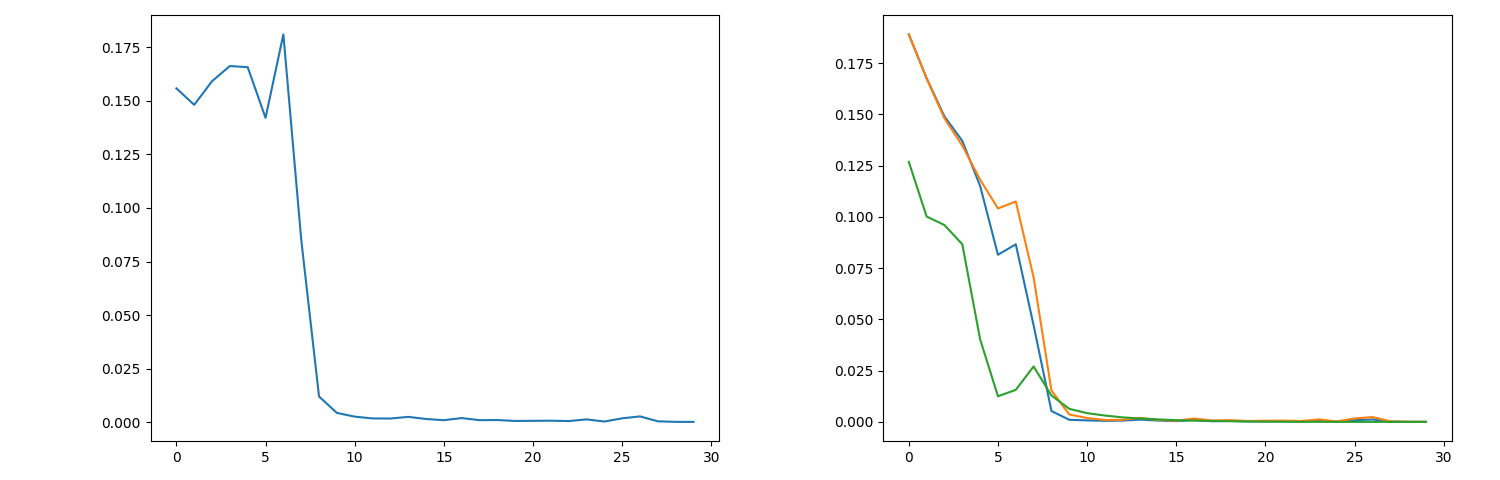

In [ ]:
f = plt.figure()
ax = f.subplots(1,2)
ax[0].plot(epoch_loss_log)
ax[1].plot(epoch_c_log)
f.tight_layout()
f.set_figwidth(15)

In [ ]:
optimizer._dual_vars

tensor([0.3958, 0.4311, 0.2161], grad_fn=<AddBackward0>)

Overall MSE
tensor(3.1276e-05)
MSE on jacobian-hessian relation
tensor(4.8533e-05)
MSE on x=0
tensor(7.8236e-05)
MSE on x=1
tensor(5.1715e-05)
MSE on t=0
tensor(2.5128e-05)


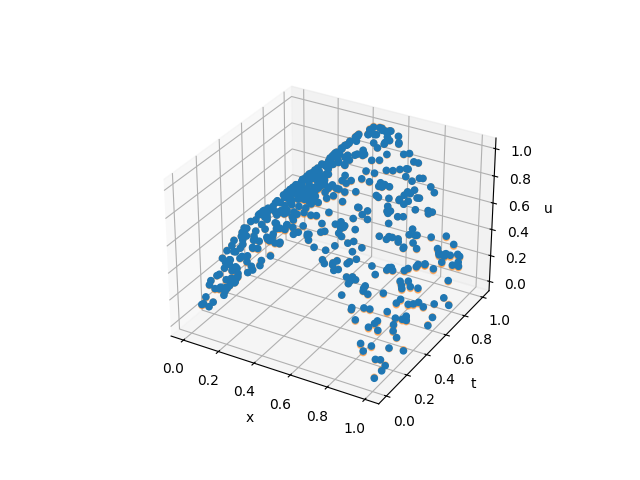

In [ ]:
%matplotlib ipympl


torch.manual_seed(0)
x = torch.rand(500).requires_grad_()
t = torch.rand(500).requires_grad_()
preds = model(torch.vstack((x, t)).T).unbind()
jac_t = torch.autograd.grad(
        outputs=preds,
        inputs=t,
        grad_outputs=None,
        create_graph=True,
        materialize_grads=True)[0]
hess_x = torch.autograd.grad(
        outputs=jac_x.unbind(),
        inputs=x,
        create_graph=True,
        materialize_grads=True)[0]
loss_d = torch.nn.functional.mse_loss(jac_t, alpha*hess_x).detach()

with torch.inference_mode():
    _u = u(x, t, alpha=alpha)
    preds = model(torch.vstack((x, t)).T).flatten()
    print('Overall MSE')
    print(torch.nn.functional.mse_loss(preds, _u))
    print('MSE on jacobian-hessian relation')
    print(loss_d)
    print('MSE on x=0')
    print(torch.nn.functional.mse_loss(model(torch.vstack((torch.zeros_like(t), t)).T).squeeze(), torch.zeros_like(preds)))
    print('MSE on x=1')
    print(torch.nn.functional.mse_loss(model(torch.vstack((torch.ones_like(t), t)).T).squeeze(), torch.zeros_like(preds)))
    print('MSE on t=0')
    print(torch.nn.functional.mse_loss(model(torch.vstack((x, torch.zeros_like(x))).T).squeeze(), torch.sin(torch.pi*x)))

    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(xs=x, ys=t, zs=_u, alpha=1)
    ax.scatter(xs=x, ys=t, zs=preds,alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')